# Feature elimination

In [187]:
import sys
sys.path.insert(0, '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing')
from dp_utils import *
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
data_path = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/EQs/EQ_3.h5'
df = pd.read_hdf(data_path, key = 'table')
df.columns = ['s','ttf']

In [188]:
config_path = "/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_config.json"
with open(config_path, 'rb') as config:
    params = json.load(config)

routines = params['routines']
default_window_size = params['window_size']
new_df = process_df(df, routines,default_window_size)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_config.json'

In [13]:
save_to = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/featurized_data_EQ_3.h5'
new_df.to_hdf(save_to, key = 'table')

Preparing the data

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = new_df.loc[:, new_df.columns != 'ttf']
X = np.array(X)
scaler.fit(X)
X = scaler.transform(X)
y = np.array(new_df.ttf)

# Removing features with low variance

In [15]:
from sklearn.feature_selection import VarianceThreshold
print("было: ",len(new_df.columns))
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected_features = sel.fit_transform(new_df)
print("стало: ",selected_features.shape[1])

было:  8
стало:  6


# Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.

**SelectKBest** removes all but the  highest scoring features.

The methods based on **F-test** estimate the degree of linear dependency between two random variables. On the other hand, **mutual information** methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

In [19]:
from sklearn.feature_selection import SelectKBest,SelectFpr, SelectFdr
from sklearn.feature_selection import f_regression, mutual_info_regression
X_new = SelectKBest(mutual_info_regression, k=3).fit_transform(X, y)
print(X_new.shape)

(4443, 3)


**SelectFpr**

Filter: Select the pvalues below alpha based on a FPR test.

FPR test stands for False Positive Rate test. It controls the total amount of false detections.

In [20]:
X_new = SelectFpr(f_regression,alpha = 0.1).fit_transform(X, y)
print(X_new.shape)

(4443, 5)


/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:560: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha


**SelectFdr**

Filter: Select the p-values for an estimated false discovery rate

This uses the Benjamini-Hochberg procedure. alpha is an upper bound on the expected false discovery rate.

In [21]:
X_new = SelectFdr(f_regression,alpha = 0.1).fit_transform(X, y)
print(X_new.shape)

(4443, 5)


/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:619: RuntimeWarning: invalid value encountered in less_equal
  np.arange(1, n_features + 1)]
/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:622: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()


# Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (**RFE**) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [22]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

In [9]:
estimator = DTR()
selector = RFE(estimator, 3, step=1)

selector = selector.fit(X, y)
print(selector.support_) 
print("Remaining features: ")
print([col for indicator, col in zip(selector.support_,list(new_df.columns)) if indicator == True])
print(selector.ranking_)

[ True  True False False False False  True]
Remaining features: 
['w_abs_energy(s, window_size=5000)', 'w_absolute_sum_of_changes(s, window_size=15000)', 'w_savgol_filter(w_psd(s, window_size=10000, fs=4000000.0), window_size=9999999999, window_length=201, polyorder=1)']
[1 1 2 5 3 4 1]


In [10]:
selector

RFE(estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
  n_features_to_select=3, step=1, verbose=0)

In [166]:
estimator = RFR()
selector = RFE(estimator, 3, step=1)

selector = selector.fit(X, y)
print(selector.support_) 
print("Remaining features: ")
print([col for indicator, col in zip(selector.support_,list(new_df.columns)) if indicator == True])
print(selector.ranking_)

[ True  True False False False False  True]
Remaining features: 
['w_abs_energy(df, window_size=5000)', 'w_absolute_sum_of_changes(df, window_size=15000)', 'w_savgol_filter(df, window_size=9999999999, window_length=201, polyorder=1)']
[1 1 3 5 2 4 1]


# L1-based feature selection

Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with feature_selection.SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the linear_model.Lasso for regression, and of linear_model.LogisticRegression and svm.LinearSVC for classification

In [161]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

print(X.shape)
regressor = Lasso(alpha = 0.0015, normalize = True).fit(X, y)
model = SelectFromModel(regressor, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(4443, 7)
(4443, 2)


# Tree-based feature selection

In [147]:
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

In [148]:
print(X.shape)
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
print(clf.feature_importances_)
X_new = model.transform(X)
print(X_new.shape)

(4443, 12)
[0.06001588 0.10434405 0.05755731 0.09323816 0.05097123 0.10392757
 0.05624428 0.20129047 0.04858997 0.04929882 0.11488981 0.05963245]
(4443, 5)


# Testing elimination strategies

In [26]:
import sys
sys.path.insert(0, '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing')
from dp_features import *
from dp_utils import process_df
import pandas as pd
import json
from sklearn.feature_selection import VarianceThreshold
data_path = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/EQs/EQ_2.h5'
df_EQ2 = pd.read_hdf(data_path, key = 'table')
df_EQ2.columns = ['s','ttf']

In [27]:
config_path = "/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/configs/dp_config.json"
with open(config_path, 'rb') as config:
    params = json.load(config)

routines = params['routines']
default_window_size = params['window_size']
df_EQ2 = process_df(df_EQ2, routines,default_window_size, df_path = '../data/test_EQ2')

/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_utils.py:143: UserWarning: Directory ../data/test_EQ2 already exists. Running data processing in this directory again might lead to data loss.
  warnings.warn(f"Directory {df_path} already exists. "


Calculation of 44 features...
File w_psd(s, window_size=10000, fs=4000000.0).h5 already exists. Skip calculations and append it to the dataframe
Feature w_periodogram calcualtion is disabled
File w_abs_energy(s, window_size=5000).h5 already exists. Skip calculations and append it to the dataframe
File w_absolute_sum_of_changes(s, window_size=15000).h5 already exists. Skip calculations and append it to the dataframe
Feature w_approximate_entropy calcualtion is disabled
File w_autocorrelation(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_autocorrelation(s, window_size=10000, lag=10).h5 already exists. Skip calculations and append it to the dataframe
File w_binned_entropy(s, window_size=10000, max_bins=10).h5 already exists. Skip calculations and append it to the dataframe
File w_c3(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_con(s, window_size=10000).h5 already exists

In [127]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = StandardScaler()
X_EQ2 = df_EQ2.loc[:, df_EQ2.columns != 'ttf']
X_cols_EQ2 = X_EQ2.columns
X_EQ2 = np.array(X_EQ2)
scaler.fit(X_EQ2)
X_EQ2 = scaler.transform(X_EQ2)
y_EQ2 = np.array(df_EQ2.ttf)

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [137]:
from sklearn.feature_selection import SelectKBest,SelectFpr, SelectFdr, SelectPercentile
from sklearn.feature_selection import f_regression, mutual_info_regression

selector_univariate = SelectPercentile(mutual_info_regression, percentile = 70).fit(X_EQ2, y_EQ2)

def eliminate_features(eliminator, X, cols):
    return X_EQ2[:,eliminator.get_support()], list(cols[list(eliminator.get_support())])

def get_feature_importance(selector, features):
    l = sorted(list(zip(list(selector.scores_), list(features))), key = lambda t: -t[0]) 
    return [el[0] for el in l], [el[1] for el in l]

X_EQ2_new, X_cols_EQ2_new = eliminate_features(selector_univariate, X_EQ2, X_cols_EQ2)

/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [136]:
print("Remaining features: ")
features_remain = X_cols_EQ2_new
print(features_remain)

Remaining features: 
['w_psd(s, window_size=10000, fs=4000000.0)', 'w_abs_energy(s, window_size=5000)', 'w_absolute_sum_of_changes(s, window_size=15000)', 'w_autocorrelation(s, window_size=10000, lag=100)', 'w_autocorrelation(s, window_size=10000, lag=10)', 'w_binned_entropy(s, window_size=10000, max_bins=10)', 'w_c3(s, window_size=10000, lag=100)', 'w_con(s, window_size=10000)', 'w_count_above_mean(s, window_size=10000)', 'w_count_below_mean(s, window_size=10000)', 'w_eta_e(s, window_size=10000)', 'w_gskew(s, window_size=10000)', 'w_kurtosis(s, window_size=10000)', 'w_longest_strike_above_mean(s, window_size=10000)', 'w_longest_strike_below_mean(s, window_size=10000)', 'w_max(s, window_size=10000)', 'w_mean(s, window_size=10000)', 'w_mean_abs_change(s, window_size=10000)', 'w_median(s, window_size=10000)', 'w_median_BRP(s, window_size=10000)', 'w_min(s, window_size=10000)', 'w_number_cwt_peaks(s, window_size=10000, n=1)', 'w_q31(s, window_size=10000)', 'w_quantile(s, window_size=10000

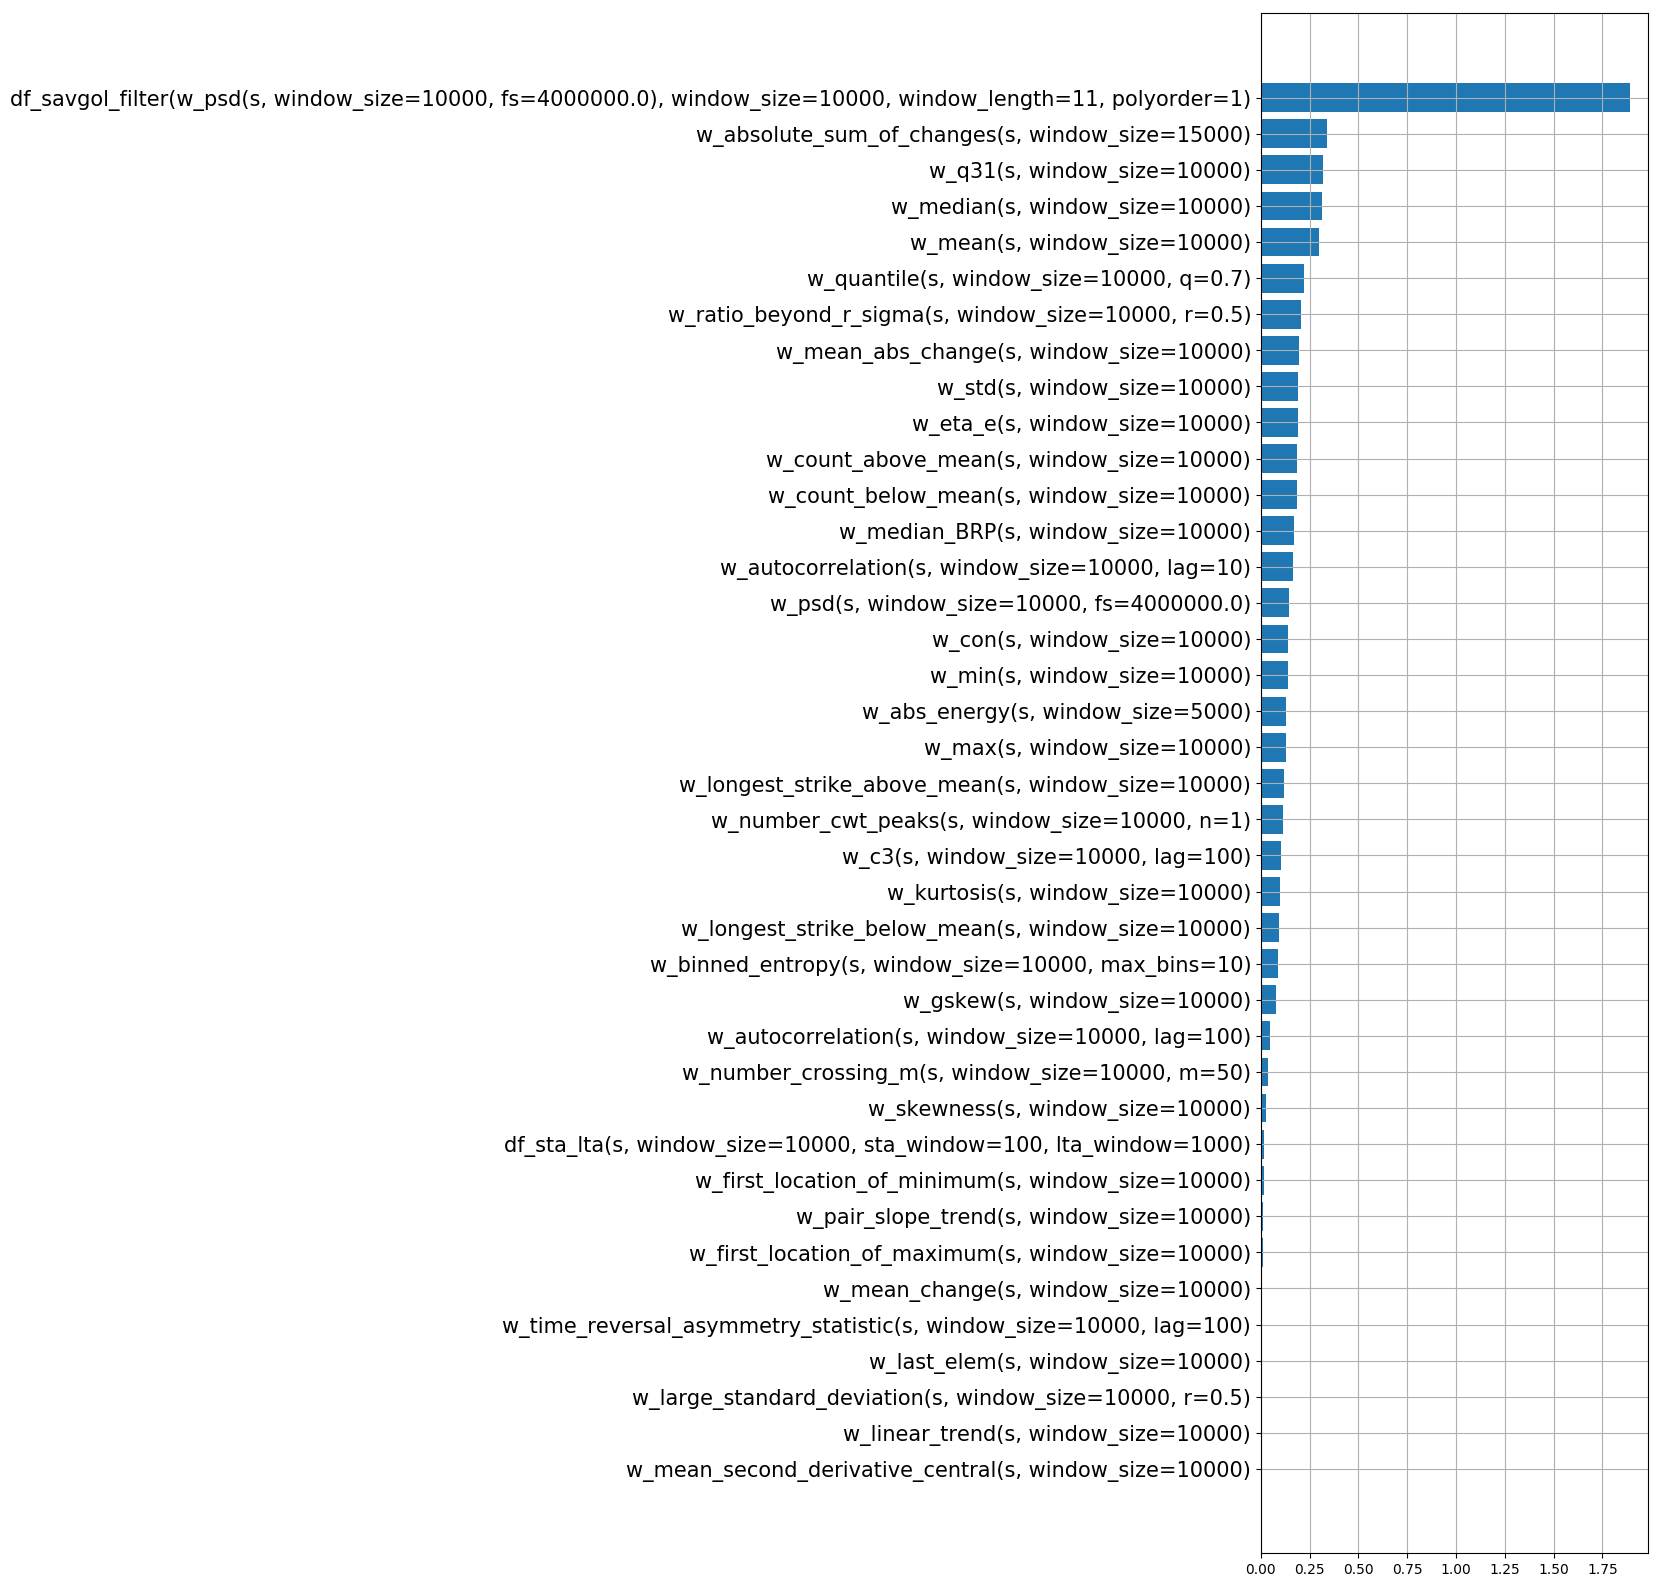

In [138]:
features = df_EQ2.columns
from matplotlib import pyplot as plt
from matplotlib import transforms
scores_sorted, features_sorted = get_feature_importance(selector_univariate, features)
scores_sorted = scores_sorted[::-1]
features_sorted = features_sorted[::-1]

def bar_chart(features, scores):
    fig = plt.figure(figsize = (5,20))
    ax = plt.barh(np.arange(len(scores_sorted)),scores_sorted, orientation = 'horizontal') #,
    plt.grid(True)
    plt.yticks(np.arange(len(features_sorted)), features_sorted, rotation = 0, size = 15) 
    plt.yticks(size = 15) 

    plt.show()

bar_chart(features_sorted, scores_sorted)

# Testing recursive feature elimination

In [97]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

estimator = RFR()
selector_recursive = RFE(estimator, 10, step=1, verbose = 100)
selector_recursive = selector_recursive.fit(new_X_EQ2, y_EQ2)
print("Remaining features: ")
print([col for indicator, col in zip(selector_recursive.support_,list(new_X_EQ2_cols)) if indicator == True])
print(selector_recursive.ranking_)

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
[False  True  True False  True  True  True False False False False False
 False False False False  True  True False False False  True False False
  True False  True]
Remaining features: 
['w_abs_energy(s, window_size=5000)', 'w_absolute_sum_of_changes(s, window_size=15000)', 'w_autocorrelation(s, window_size=10000, lag=10)', 'w_binned_entropy(s, window_size=10000, max_bins=10)', 'w_c3(

In [98]:
from sklearn.metrics import mean_absolute_error as mae
print(mae(y_EQ2,selector_recursive.predict(new_X_EQ2)))

0.718217006191494


In [99]:
# Simple Validation
data_path = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/EQs/EQ_3.h5'
df_EQ3 = pd.read_hdf(data_path, key = 'table')
df_EQ3.columns = ['s','ttf']
config_path = "/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/configs/dp_config.json"
with open(config_path, 'rb') as config:
    params = json.load(config)

routines = params['routines']
default_window_size = params['window_size']
df_EQ3 = process_df(df_EQ3, routines,default_window_size, df_path = '../data/test_EQ3')

X_EQ3 = df_EQ3.loc[:, df_EQ3.columns != 'ttf']
X_EQ3 = np.array(X_EQ3)
X_EQ3 = scaler.transform(X_EQ3)

new_X_EQ3 = X_EQ3[:,selector_univariate.get_support()]
new_X_EQ3_cols = df_EQ3.columns[:-1][list(selector_univariate.get_support())]
y_EQ3 = df_EQ3['ttf']

/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_utils.py:143: UserWarning: Directory ../data/test_EQ3 already exists. Running data processing in this directory again might lead to data loss.
  warnings.warn(f"Directory {df_path} already exists. "


Calculation of 44 features...
File w_psd(s, window_size=10000, fs=4000000.0).h5 already exists. Skip calculations and append it to the dataframe
Feature w_periodogram calcualtion is disabled
File w_abs_energy(s, window_size=5000).h5 already exists. Skip calculations and append it to the dataframe
File w_absolute_sum_of_changes(s, window_size=15000).h5 already exists. Skip calculations and append it to the dataframe
Feature w_approximate_entropy calcualtion is disabled
File w_autocorrelation(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_autocorrelation(s, window_size=10000, lag=10).h5 already exists. Skip calculations and append it to the dataframe
File w_binned_entropy(s, window_size=10000, max_bins=10).h5 already exists. Skip calculations and append it to the dataframe
File w_c3(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_con(s, window_size=10000).h5 already exists

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [100]:
from sklearn.metrics import mean_absolute_error as mae
print(mae(y_EQ3,selector_recursive.predict(new_X_EQ3)))

2.9429370094430043


# Testing lasso

In [120]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

X_EQ2 = df_EQ2.loc[:, df_EQ2.columns != 'ttf']
# X_EQ2 = new_df
X_EQ2 = np.array(X_EQ2)
scaler.fit(X_EQ2)
X_EQ2 = scaler.transform(X_EQ2)
y_EQ2 = np.array(df_EQ2.ttf)
print(X_EQ2.shape)
print(df_EQ2.columns)

print(X_EQ2.shape)
regressor = Lasso(alpha = 0.05, normalize = False).fit(X_EQ2, y_EQ2)
model = SelectFromModel(regressor, prefit=True)
X_new_EQ2 = model.transform(X_EQ2)
print(X_new_EQ2.shape)

(4443, 39)
Index(['w_psd(s, window_size=10000, fs=4000000.0)',
       'w_abs_energy(s, window_size=5000)',
       'w_absolute_sum_of_changes(s, window_size=15000)',
       'w_autocorrelation(s, window_size=10000, lag=100)',
       'w_autocorrelation(s, window_size=10000, lag=10)',
       'w_binned_entropy(s, window_size=10000, max_bins=10)',
       'w_c3(s, window_size=10000, lag=100)', 'w_con(s, window_size=10000)',
       'w_count_above_mean(s, window_size=10000)',
       'w_count_below_mean(s, window_size=10000)',
       'w_eta_e(s, window_size=10000)',
       'w_first_location_of_maximum(s, window_size=10000)',
       'w_first_location_of_minimum(s, window_size=10000)',
       'w_gskew(s, window_size=10000)', 'w_kurtosis(s, window_size=10000)',
       'w_large_standard_deviation(s, window_size=10000, r=0.5)',
       'w_last_elem(s, window_size=10000)',
       'w_linear_trend(s, window_size=10000)',
       'w_longest_strike_above_mean(s, window_size=10000)',
       'w_longest_strike

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [124]:
new_X_EQ2_cols = df_EQ2.columns[:-1][list(model.get_support())]
print(mae(y_EQ3,regressor.predict(X_EQ3)))

3.1820677610662407
